In [1]:
### ipyleaflet required to run the map codes in data exploration
# !pip install ipyleaflet

# Use these commands in terminal
### Install ipyleaflet:                conda install -c conda-forge ipyleaflet
### Install Node.js:                   conda install -c anaconda nodejs
### Install the JupyterLab extension:  jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

# RUN THE FOLLOWING COMMAND IN JUPYTER TERMINAL
# jupyter labextension develop . --overwrite

In [2]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import ipyleaflet as ipy
# from synapse.ml.isolationforest.IsolationForest import IsolationForest

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Isolation Forest
from pyspark.ml.util import JavaMLReadable, JavaMLWritable
from synapse.ml.core.platform import running_on_synapse_internal
# from synapse.ml.core.serialize.java_params_patch import *
from pyspark.ml.wrapper import JavaTransformer, JavaEstimator, JavaModel
from pyspark.ml.evaluation import JavaEvaluator
from pyspark.ml.common import inherit_doc
# from synapse.ml.core.schema.Utils import *
from pyspark.ml.param import TypeConverters
# from synapse.ml.core.schema.TypeConversionUtils import generateTypeConverter, complexTypeConverter
# from synapse.ml.isolationforest.IsolationForestModel import IsolationForestModel
# from synapse.ml.isolationforest import *

Matplotlib created a temporary cache directory at /scratch/jtayag/job_30698557/matplotlib-ci8yf1sx because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
### Notes from prof's example notebook
# #Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting. (presumably 2GB per core)

### For server
# 32 nodes
# 64g

## Start Spark context
total_nodes = 20
memory_per_node = 160

driver_memory = f"{memory_per_node}g"
executor_memory = f"{int(memory_per_node/total_nodes)}g"
n_executors = total_nodes - 1
print(f"Driver memory: {driver_memory}\nExecutor memory: {executor_memory}\nNumber of executors: {n_executors}\n")
try:
    print("Initializing SparkContext")
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
    
                             # .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             # .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .appName("MyApp") \
                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

# Add sc parameters
sc.getActiveSession()
# sc.builder.appName("Read CSV").getOrCreate()
# sc.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Driver memory: 160g
Executor memory: 8g
Number of executors: 19

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [491]:
%%time
### Load datasets
df_type = 30

### Open the preprocessed dataset
df = sqlContext.read.load("preprocessed_df_single_2/preprocessed_df_1.parquet").cache() 
df_count = df.count()

# metadata
meta_filename = "metadata_preprocessed.csv"
df_meta = sc.read.csv(meta_filename, inferSchema=True, header=True)
df_meta_count = df_meta.count()

### Comments
print(f"30min dataset has {df_count} rows")
df.show(3)
print(f"Meta dataset has {df_meta_count} rows")
df_meta.show(3)
print("/nTable schemas/n")
print(f"Schema of the {df_type} min time series data table") ###
df.printSchema()
print("Schema of the metadata table")
df_meta.printSchema()

### Since metadata table is so small, convert to Pandas
df_meta = df_meta.toPandas()

30min dataset has 54919174 rows
+---+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|ss_id|stamp_date|     power_kW_values|        coefficients|     reconstructions|                  PC|                 PC1|                 PC2|
+---+-----+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0| 2405|2012-01-21|[0.0, 0.0, 0.0, 0...|[0.49785779737625...|[0.00410907621307...|[-0.0978108927705...|-0.09781089277057363|-0.06721326394047944|
|  1| 2405|2012-02-15|[0.0, 0.0, 0.0, 0...|[1.27955253409150...|[-5.8784316146980...|[-0.4175436088111...|-0.41754360881115216| -0.4522227105208571|
|  2| 2405|2012-07-25|[0.0, 0.0, 0.0, 0...|[1.77050233549690...|[-0.0294082997826...|[-0.0693224464859...|-0.06932244648597538|-0.24449205499426538|
+---+-----+----------+--------------------+--------------------+----------

In [5]:
%%time
### Load the basis
basis = pd.read_csv("basis.csv", header=None).to_numpy()

print("Shape of basis:", basis.shape)
print()
basis

Shape of basis: (21, 48)

CPU times: user 2.38 ms, sys: 88.7 ms, total: 91.1 ms
Wall time: 191 ms


array([[ 0.14433757,  0.14433757,  0.14433757, ...,  0.14433757,
         0.14433757,  0.14433757],
       [ 0.20412415,  0.20237783,  0.19716878, ...,  0.18858612,
         0.19716878,  0.20237783],
       [ 0.        ,  0.02664355,  0.05283122, ..., -0.07811493,
        -0.05283122, -0.02664355],
       ...,
       [ 0.        ,  0.18858612,  0.14433757, ...,  0.07811493,
        -0.14433757, -0.18858612],
       [ 0.20412415,  0.05283122, -0.1767767 , ..., -0.14433757,
        -0.1767767 ,  0.05283122],
       [ 0.        ,  0.19716878,  0.10206207, ...,  0.14433757,
        -0.10206207, -0.19716878]])

In [6]:
%%time
### Load the covariance matrix
cov = pd.read_csv("coefficient_cov.csv", header=None).to_numpy()

print("Shape of coefficient covariance matrix:", cov.shape)
print()

Shape of coefficient covariance matrix: (21, 21)

CPU times: user 953 µs, sys: 962 µs, total: 1.92 ms
Wall time: 18.9 ms


In [7]:
%%time
### Load the column means
colMeans = pd.read_csv("coefficient_means.csv", header=None).to_numpy()

print("Shape of coefficient means:", colMeans.shape)
print()
colMeans

Shape of coefficient means: (21, 1)

CPU times: user 1.74 ms, sys: 0 ns, total: 1.74 ms
Wall time: 7.84 ms


array([[-1.00510204],
       [-0.98480642],
       [-1.0164157 ],
       [-1.00786856],
       [-1.00653602],
       [-0.99437608],
       [-1.03694155],
       [-0.97115596],
       [-1.01308927],
       [-0.99315121],
       [-0.99389083],
       [-1.02358324],
       [-0.90186588],
       [-1.02419345],
       [-0.99479181],
       [-1.00859487],
       [-1.00940899],
       [-1.01089387],
       [-0.96880138],
       [-0.97376163],
       [-1.00517694]])

Almost all of the variance is explained by the first PC, but two PCs will be used in this analysis
Up to vector 0: 0.0
Up to vector 1: 99.98117750476253
Up to vector 2: 99.9999999959597
Up to vector 3: 99.99999999691997
Up to vector 4: 99.99999999765934
Up to vector 5: 99.99999999804778
Up to vector 6: 99.99999999840338
Up to vector 7: 99.9999999987146
Up to vector 8: 99.99999999893092
Up to vector 9: 99.99999999913298
Up to vector 10: 99.9999999993042
Up to vector 11: 99.99999999947215
Up to vector 12: 99.99999999959581
Up to vector 13: 99.99999999969218
Up to vector 14: 99.99999999977537
Up to vector 15: 99.99999999984217
Up to vector 16: 99.99999999989643
Up to vector 17: 99.99999999994826
Up to vector 18: 99.99999999998418
Up to vector 19: 99.99999999999515
Up to vector 20: 99.99999999999977


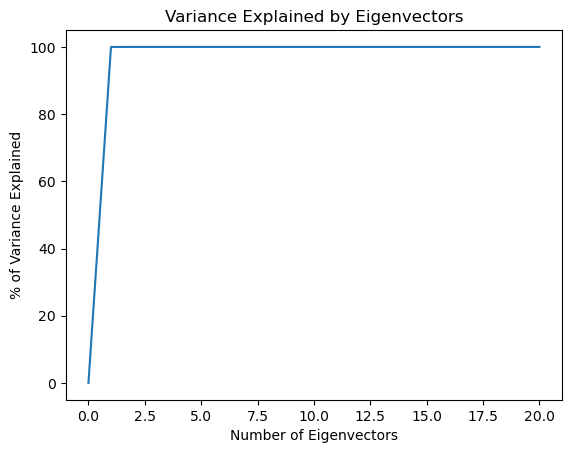

CPU times: user 169 ms, sys: 141 ms, total: 309 ms
Wall time: 374 ms


In [8]:
%%time
### Get eigval/eigvecs ordered by eigval magnitude, then view the explained variance
def get_ordered_eigval_eigvec(cov):
    ### Extract the eigenvalues and eigenvectors, then output them ordered by eigenvalue magnitude
    eigval, eigvec = np.linalg.eig(cov)
    eigval_ind = np.argsort(np.absolute(eigval))[::-1]
    output = [eigval[eigval_ind], eigvec[eigval_ind]]
    
    return output

def plot_explained_variance(eigval, max_num = None):
    ### View the amount of variance explained by each eigvenvector
    if max_num is None:
        max_num = len(eigval)
    total_var = np.sum(np.absolute(eigval))
    explained_var = []
    for i in range(0,max_num):
        explained_var.append((sum(np.absolute(eigval[:i])) / total_var) * 100)
        print(f"Up to vector {i}: {explained_var[i]}")
        
    plt.plot(range(0,max_num), explained_var)
    plt.title("Variance Explained by Eigenvectors")
    plt.xlabel("Number of Eigenvectors")
    plt.ylabel("% of Variance Explained")
    plt.show()

eigval, eigvec = get_ordered_eigval_eigvec(cov)

print("Almost all of the variance is explained by the first PC, but two PCs will be used in this analysis")
plot_explained_variance(eigval)

# PCA Analysis on Coefficients for Anomaly Detection

CPU times: user 1min 50s, sys: 11.2 s, total: 2min 1s
Wall time: 2min 10s


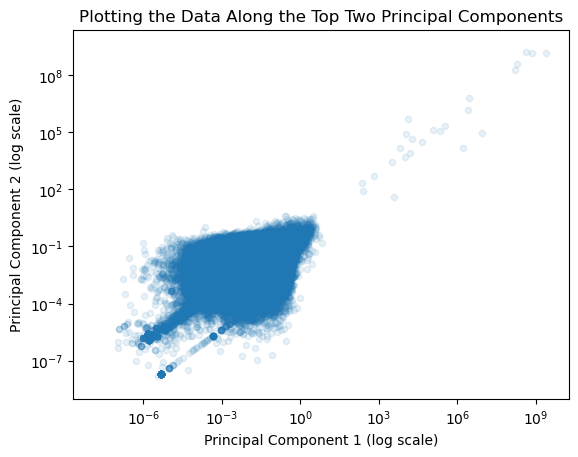

In [9]:
%%time
### Plot the data along the top two principal components (use a log scale on the axes)
df.select("PC1","PC2").toPandas().plot.scatter("PC1", "PC2", alpha=0.1)
plt.xlabel("Principal Component 1 (log scale)")
plt.ylabel("Principal Component 2 (log scale)")
plt.title("Plotting the Data Along the Top Two Principal Components")
plt.xscale("log")
plt.yscale("log")

Outliers seem present where PC1 > 10^2 (100)

In [10]:
%%time
### Examining the correlation between PC1 and PC2
vecAssembler = VectorAssembler(inputCols=["PC1", "PC2"], outputCol="features")
pearsonCorr = Correlation.corr(vecAssembler.transform(df), "features", "pearson").collect()[0][0]

CPU times: user 4.7 ms, sys: 5.95 ms, total: 10.6 ms
Wall time: 21.2 s


In [11]:
print("Global correlation matrix between PC1 and PC2:\n\n", pearsonCorr.toArray())
print()
print("PC1 and PC2 are not very highly correlated with one another globally")

Global correlation matrix between PC1 and PC2:

 [[1.         0.05867829]
 [0.05867829 1.        ]]

PC1 and PC2 are not very highly correlated with one another globally


In [12]:
%%time
### Isolate the outlier points
print("Number of outlier points:", df.where(F.col("PC1") > 10).count())
print()
df.where(F.col("PC1") > 10).select("id", "ss_id", "stamp_date", "PC1", "PC2").show(50)
print()

Number of outlier points: 45

+------------+-----+----------+--------------------+--------------------+
|          id|ss_id|stamp_date|                 PC1|                 PC2|
+------------+-----+----------+--------------------+--------------------+
| 34359900110|11166|2017-10-19|  220427.61736152528|  -63085.38672507865|
| 34360134405| 7928|2018-02-19|   118191.8487288496|  131782.99681298772|
| 42950064702| 6565|2012-10-20| 2.199499038930854E7|  -9311714.562992591|
| 42950101932| 9447|2014-02-25|   46455.96846742528|   30424.30058779601|
| 51539734442| 6653|2012-10-24|   6676.992685471917|  14335.339732232467|
| 51539769922| 9447|2014-02-23|  3907.0624900335106| -15410.236093417836|
| 60129952648| 6653|2012-10-17|  1227.9719552059908|  -16092.41468708491|
| 60129974139| 8337|2013-11-20|   9873.516109821308|     5054.0520836881|
|103079661604| 8337|2013-11-28|   5449.052626767417|  -2596.725776054057|
|137439388495| 6565|2012-10-19|3.2927793125243694E7|   -4527212.65266712|
|1717988

Text(0, 0.5, 'Principal Component 2 (log scale)')

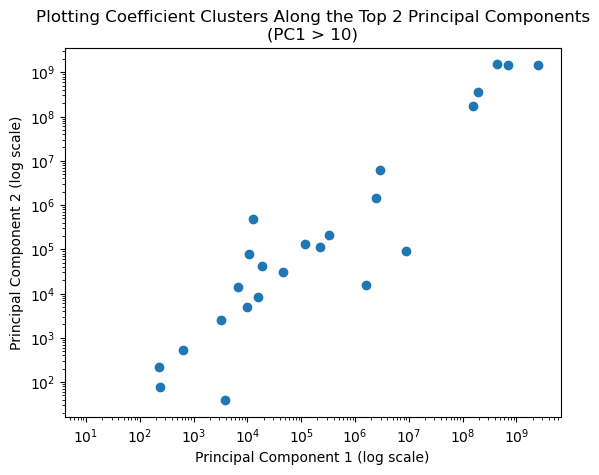

In [13]:
pca_outliers = df.where(F.col("PC1") > 10) \
                 .select("id", "ss_id", "stamp_date", "PC1", "PC2") \
                 .toPandas()

plt.scatter(pca_outliers["PC1"], pca_outliers["PC2"])
plt.xscale("log")
plt.yscale("log")
plt.title("Plotting Coefficient Clusters Along the Top 2 Principal Components\n(PC1 > 10)")
plt.xlabel("Principal Component 1 (log scale)")
plt.ylabel("Principal Component 2 (log scale)")

In [14]:
print("Within this set of outliers, PC1 and PC2 are highly correlated")
pca_outliers[["PC1", "PC2"]].corr()

Within this set of outliers, PC1 and PC2 are highly correlated


,PC1,PC2
PC1,1.000000,0.763733
PC2,0.763733,1.000000


CPU times: user 187 ms, sys: 8.47 ms, total: 195 ms
Wall time: 845 ms


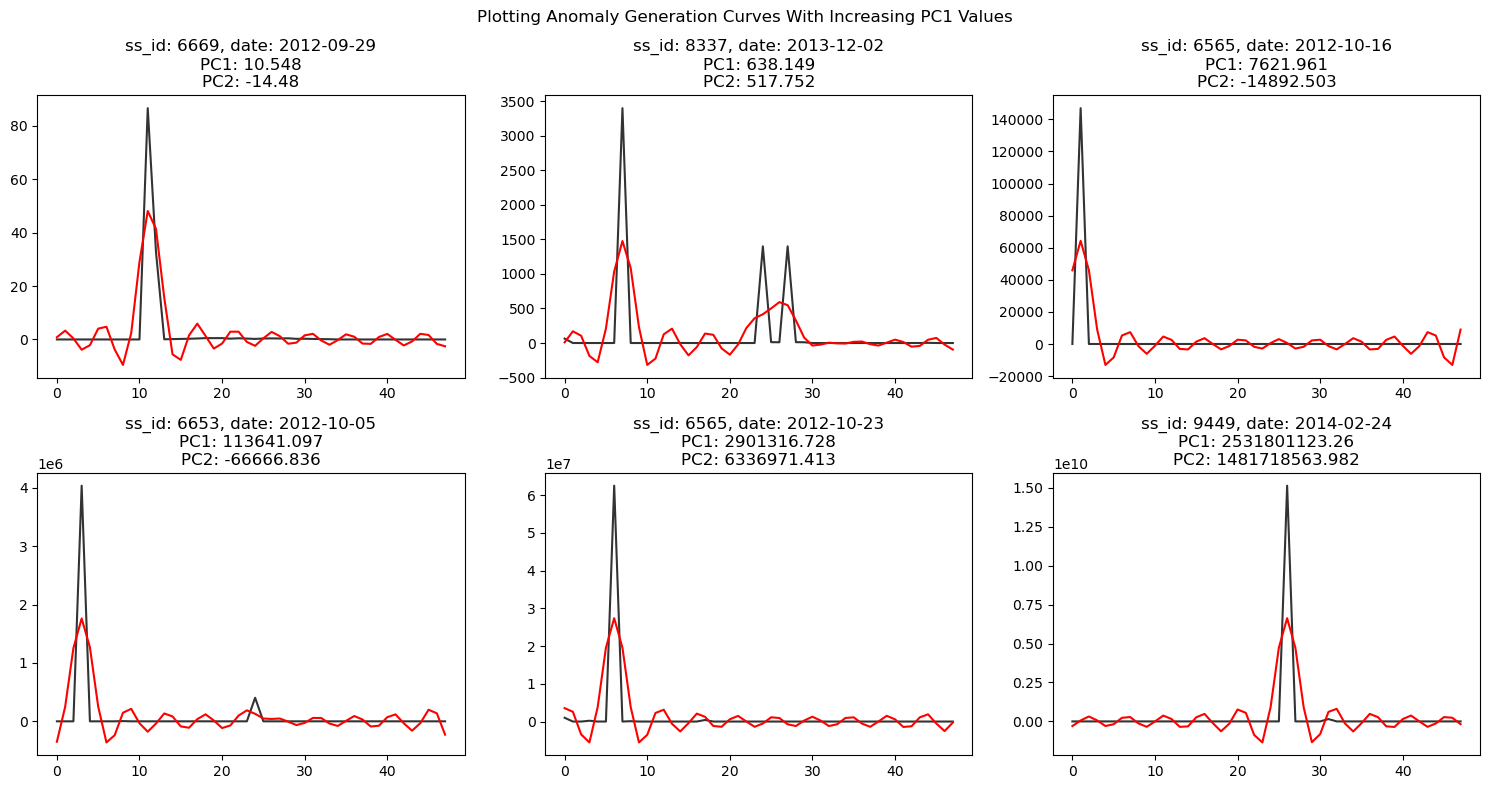

In [15]:
%%time
# Visualizing the outliers by increasing PC1 values
ind = [int(i) for i in np.linspace(0, len(pca_outliers)-1, 6)]
ind

x = [i for i in range(0, 48)]

fig, axes = plt.subplots(2,3, figsize=(15,8))
for i,ax in zip(ind, axes.flatten()):
    subset = pca_outliers.sort_values("PC1").reset_index(drop=True).loc[i, :]
    id = subset["id"]
    ss_id = subset["ss_id"]
    date = subset["stamp_date"]
    pc1 = np.round(subset["PC1"], 3)
    pc2 = np.round(subset["PC2"], 3)
    reconstructions, power_kW_values = df.where(F.col("id")==id).select("reconstructions", "power_kW_values").collect()[0]

    # Plot the values vs reconstructions
    ax.plot(x, power_kW_values, linestyle="-", c="k", alpha=0.8)
    ax.plot(x, reconstructions, linestyle="-", c="r", alpha=1)
    ax.set(title=f"ss_id: {ss_id}, date: {date}\nPC1: {pc1}\nPC2: {pc2}")
plt.suptitle("Plotting Anomaly Generation Curves With Increasing PC1 Values")
fig.tight_layout()
        
    

In [16]:
%%time
### Separate out the "non_outliers" and plot them
pca_non_outliers = df.where((F.col("PC1") <= 10) & (F.col("PC2") <= 10)) \
                     .sample(0.5) \
                     .select("id", "ss_id", "stamp_date", "PC1", "PC2") \
                     .toPandas()


CPU times: user 1min 41s, sys: 8.43 s, total: 1min 49s
Wall time: 1min 54s


In [17]:
%%time
## Finding the mean PC vector excluding the outliers
pc1_mean, pc2_mean = df.where(F.col("PC1") <= 10).select(F.avg("PC1"), F.avg("PC2")).collect()[0]

print("Mean of PC1:", pc1_mean)
print("Mean of PC2:", pc2_mean)
print()

Mean of PC1: -43.15020464254202
Mean of PC2: 65.99872600025078

CPU times: user 3.51 ms, sys: 962 µs, total: 4.48 ms
Wall time: 14 s


Text(0, 0.5, 'PC2 (Log Scale)')

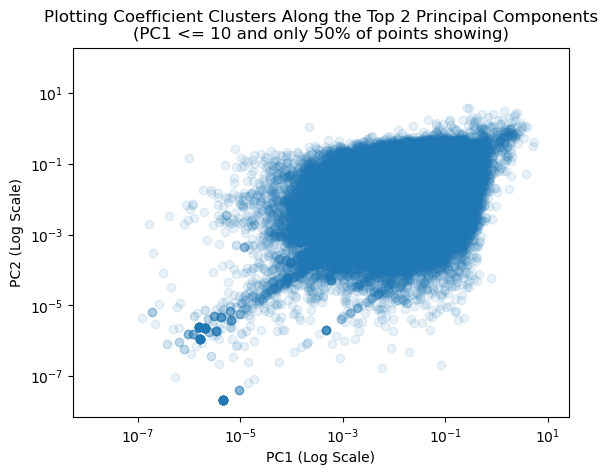

In [18]:
plt.scatter(pca_non_outliers["PC1"], pca_non_outliers["PC2"], alpha=0.1)
plt.scatter(pc1_mean, pc2_mean, marker="X", c="k")
plt.xscale("log")
plt.yscale("log")
plt.title("Plotting Coefficient Clusters Along the Top 2 Principal Components\n(PC1 <= 10 and only 50% of points showing)")
plt.xlabel("PC1 (Log Scale)")
plt.ylabel("PC2 (Log Scale)")
# plt.ylim([10**(-9), 100])


Text(0, 0.5, 'PC2')

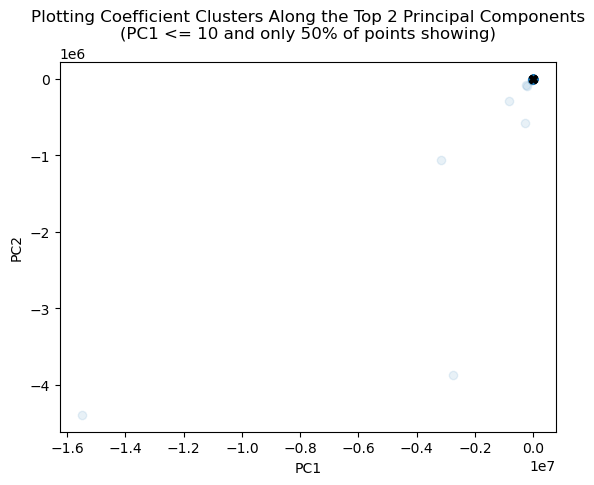

In [19]:
plt.scatter(pca_non_outliers["PC1"], pca_non_outliers["PC2"], alpha=0.1)
plt.scatter(pc1_mean, pc2_mean, marker="X", c="k")
plt.title("Plotting Coefficient Clusters Along the Top 2 Principal Components\n(PC1 <= 10 and only 50% of points showing)")
plt.xlabel("PC1")
plt.ylabel("PC2")


In [364]:
### Define functions to visualize curves and plot min/max power generation
def plot_curves(cond, sort_col, suptitle, print_text):
    # df.where(cond & cond_mean).count()
    pc_df = df.where(cond).toPandas()
    print(print_text, len(pc_df))
    
    ind = [int(i) for i in np.linspace(0, len(pc_df)-1, 6)]
    ind
    
    x = [i for i in range(0, 48)]
    
    fig, axes = plt.subplots(2,3, figsize=(15,8))
    for i,ax in zip(ind, axes.flatten()):
        subset = pc_df.sort_values(sort_col).reset_index(drop=True).loc[i, :]  ### Change sort value as needed
        id = subset["id"]
        ss_id = subset["ss_id"]
        date = subset["stamp_date"]
        pc1 = np.round(subset["PC1"], 3)
        pc2 = np.round(subset["PC2"], 3)
        reconstructions, power_kW_values = df.where(F.col("id")==id).select("reconstructions", "power_kW_values").collect()[0]
    
        # Plot the values vs reconstructions
        ax.plot(x, power_kW_values, linestyle="-", c="k", alpha=0.2)
        ax.plot(x, reconstructions, linestyle="-", c="r", alpha=1)
        ax.set(title=f"ss_id: {ss_id}, date: {date}\nPC1: {pc1}\nPC2: {pc2}")
    plt.suptitle(suptitle)
    fig.tight_layout()

    return pc_df

def plot_min_max(cutoff, pc_df, x_axis, main_scatter_size):
    pc = pc_df[["power_kW_values", x_axis]].reset_index(drop=True)
    pc["max_power"] = pc.loc[:, "power_kW_values"].apply(lambda a: max(map(float, a)) + 0.01)
    pc["min_power"] = pc.loc[:, "power_kW_values"].apply(lambda a: min(map(float, a)) + 0.01)
    pc["min_power_color"] = np.sign(pc["min_power"]-0.01).astype(int).map({0:"k", 1:"r", -1:"orange"})
    pc["size"] = np.sign(pc["min_power"]-0.01).astype(int).map({0:5, 1:5, -1:100})
    pc_zero = pc[pc["min_power"] == 0.01]
    pc_neg = pc[pc["min_power"] < 0.01]
    pc_pos = pc[pc["min_power"] > 0.01]
    
    x = [i for i in np.arange(0, len(pc))]
    
    fig,ax = plt.subplots(1,1, figsize=(7,4))
    ax1 = plt.scatter(x, pc.sort_values(x_axis, ascending=True)["max_power"], c="b", s=main_scatter_size)
    ax2 = plt.scatter(x=[i for i in pc_zero.index], y=pc_zero["min_power"], c=pc_zero["min_power_color"], s=pc_zero["size"])
    ax3 = plt.scatter(x=[i for i in pc_neg.index], y=pc_neg["min_power"], c=pc_neg["min_power_color"], s=pc_neg["size"])
    ax4 = plt.scatter(x=[i for i in pc_pos.index], y=pc_pos["min_power"], c=pc_pos["min_power_color"], s=pc_pos["size"])
    plt.legend([ax1, ax2, ax3, ax4], ["Max Power", "Min Power = 0", "Min Power < 0", "Min Power > 0"], 
              loc="upper right", bbox_to_anchor=[1.3, 1.025])
    plt.xlabel(f"{x_axis}")
    plt.ylabel("Power Generation (kW)")
    if x_axis=="PC1":
        plt.title(f"Max and Min Power Generation When PC2 < {cutoff}")
    else:
        plt.title(f"Max and Min Power Generation When PC1 < {cutoff}")
    plt.grid()
    
    print(pc.sort_values(x_axis, ascending=True)["min_power"].value_counts())

def plot_min_max_logy(cutoff, pc_df, x_axis, main_scatter_size):
    pc = pc_df[["power_kW_values", x_axis]].reset_index(drop=True)
    pc["max_power"] = pc.loc[:, "power_kW_values"].apply(lambda a: max(map(float, a)) + 0.01)
    pc["min_power"] = pc.loc[:, "power_kW_values"].apply(lambda a: min(map(float, a)) + 0.01)
    pc["min_power_color"] = np.sign(pc["min_power"]-0.01).astype(int).map({0:"k", 1:"r", -1:"orange"})
    pc["size"] = np.sign(pc["min_power"]-0.01).astype(int).map({0:5, 1:5, -1:100})
    pc_zero = pc[pc["min_power"] == 0.01]
    pc_pos = pc[pc["min_power"] > 0.01]
    
    x = [i for i in np.arange(0, len(pc))]
    
    fig,ax = plt.subplots(1,1, figsize=(7,4))
    ax1 = plt.scatter(x, pc.sort_values(x_axis, ascending=True)["max_power"], c="b", s=main_scatter_size)
    ax2 = plt.scatter(x=[i for i in pc_zero.index], y=pc_zero["min_power"], c=pc_zero["min_power_color"], s=pc_zero["size"])
    ax3 = plt.scatter(x=[i for i in pc_pos.index], y=pc_pos["min_power"], c=pc_pos["min_power_color"], s=pc_pos["size"])
    plt.legend([ax1, ax2, ax3], ["Max Power", "Min Power = 0", "Min Power > 0"], 
              loc="upper right", bbox_to_anchor=[1.3, 1.025])
    plt.yscale("log")
    plt.xlabel(f"{x_axis}")
    plt.ylabel("Power Generation (kW, Log scaled)")
    if x_axis=="PC1":
        plt.title(f"Max and Min Power Generation When PC2 < {cutoff}")
    else:
        plt.title(f"Max and Min Power Generation When PC1 < {cutoff}")
    plt.grid()
    
    print(pc.sort_values(x_axis, ascending=True)["min_power"].value_counts())


### Analyzing Low PC1 With Increasing PC2

Number of data points with PC1 < -2: 163821
CPU times: user 8.15 s, sys: 96 ms, total: 8.25 s
Wall time: 9.52 s


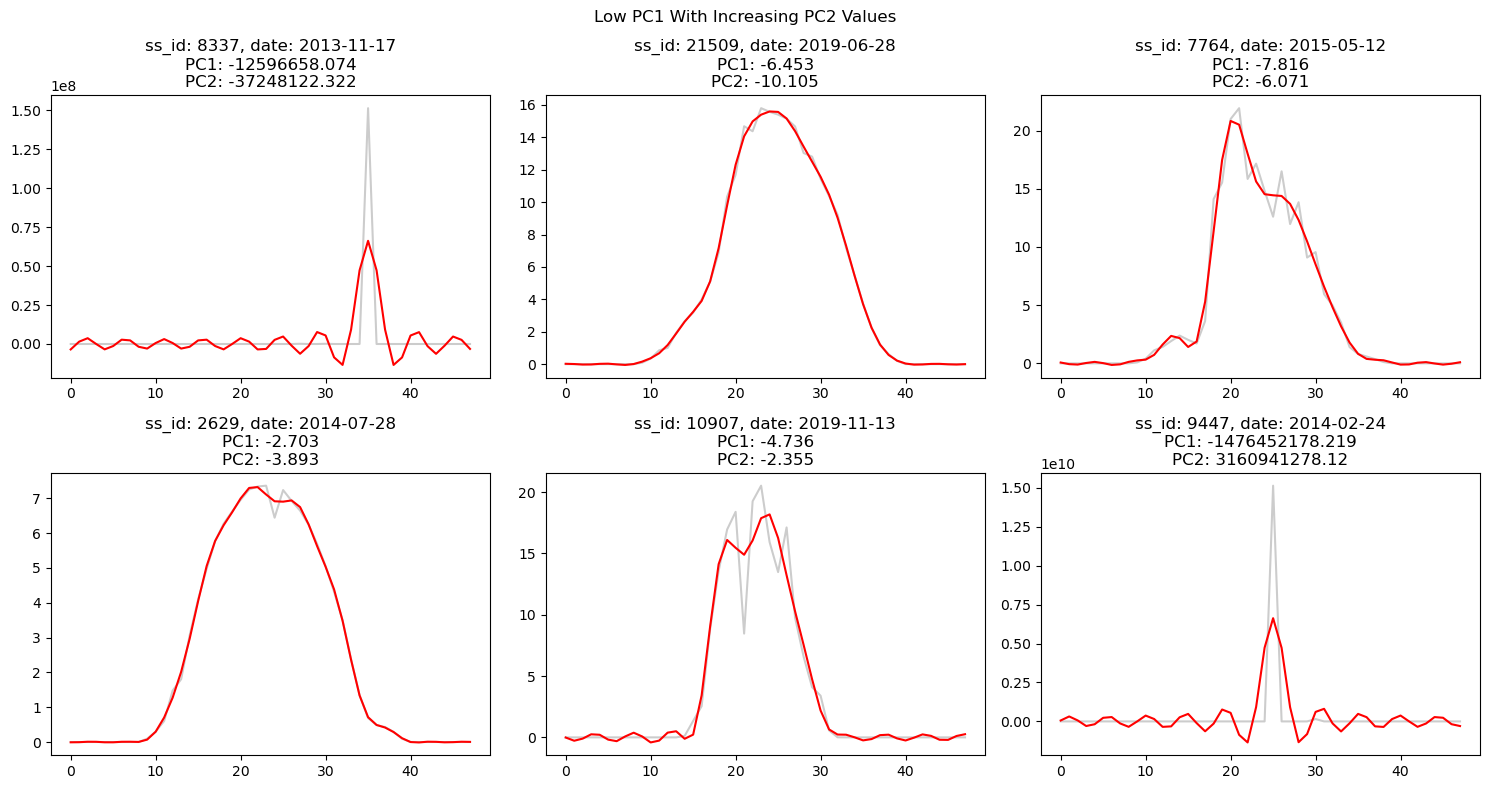

In [365]:
%%time
cutoff = -2
# Visualize power generation curves with increasing pc2 values
pc_df = plot_curves(cond = (F.col("PC1") < cutoff), # & (F.col("PC2") < pc2_mean + bound) & (F.col("PC2") > pc2_mean + bound),
                    sort_col = "PC2",
                    suptitle = "Low PC1 With Increasing PC2 Values",
                    print_text = "Number of data points with PC1 < -2:")
        

When PC1 is low, As PC2 increases, the height of the spike decreases before increasing once again

Number of data points extracted 163821
min_power
 1.000000e-02    163201
 2.800000e-02        85
 3.400000e-02        23
 3.200000e-02         9
 3.582400e-01         4
                  ...  
 2.160000e-01         1
 9.913800e-01         1
 3.673600e-01         1
 3.418800e-01         1
-1.677722e+06         1
Name: count, Length: 452, dtype: int64


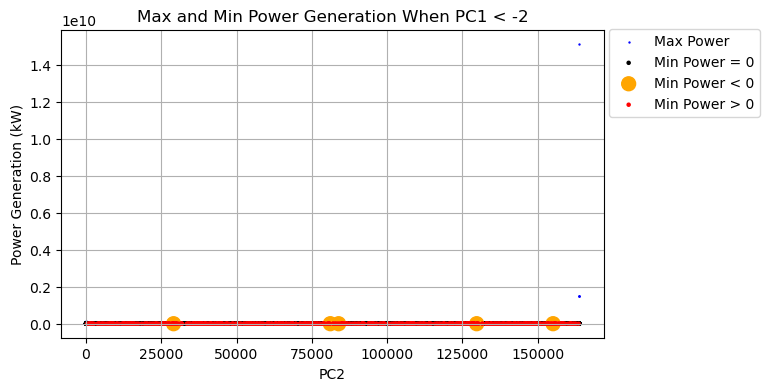

In [366]:
# Plot the maximum and minimum power_kW values for curves where PC1 < -2
print("Number of data points extracted", len(pc_df))
plot_min_max(cutoff,
             pc_df,
             x_axis = "PC2",
             main_scatter_size = 0.5)

# plt.savefig("maxmin_power_pc2fixed.png")

Number of data points extracted 163821
min_power
 1.000000e-02    163201
 2.800000e-02        85
 3.400000e-02        23
 3.200000e-02         9
 3.582400e-01         4
                  ...  
 2.160000e-01         1
 9.913800e-01         1
 3.673600e-01         1
 3.418800e-01         1
-1.677722e+06         1
Name: count, Length: 452, dtype: int64


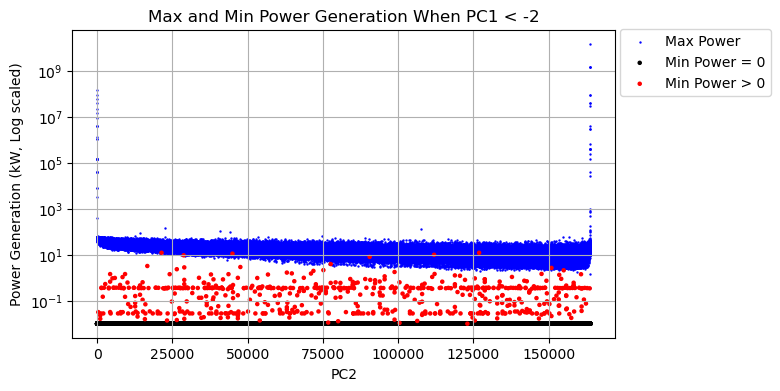

In [367]:
# Plot the maximum and minimum power_kW values for curves where PC1 < -2
print("Number of data points extracted", len(pc_df))
plot_min_max_logy(cutoff,
             pc_df,
             x_axis = "PC2",
             main_scatter_size = 0.5)

# plt.savefig("maxmin_power_pc2fixed_log.png")

### Analyzing Low PC2 With Increasing PC1

Number of data points with PC2 < -3: 173917
CPU times: user 8.71 s, sys: 122 ms, total: 8.83 s
Wall time: 10.2 s


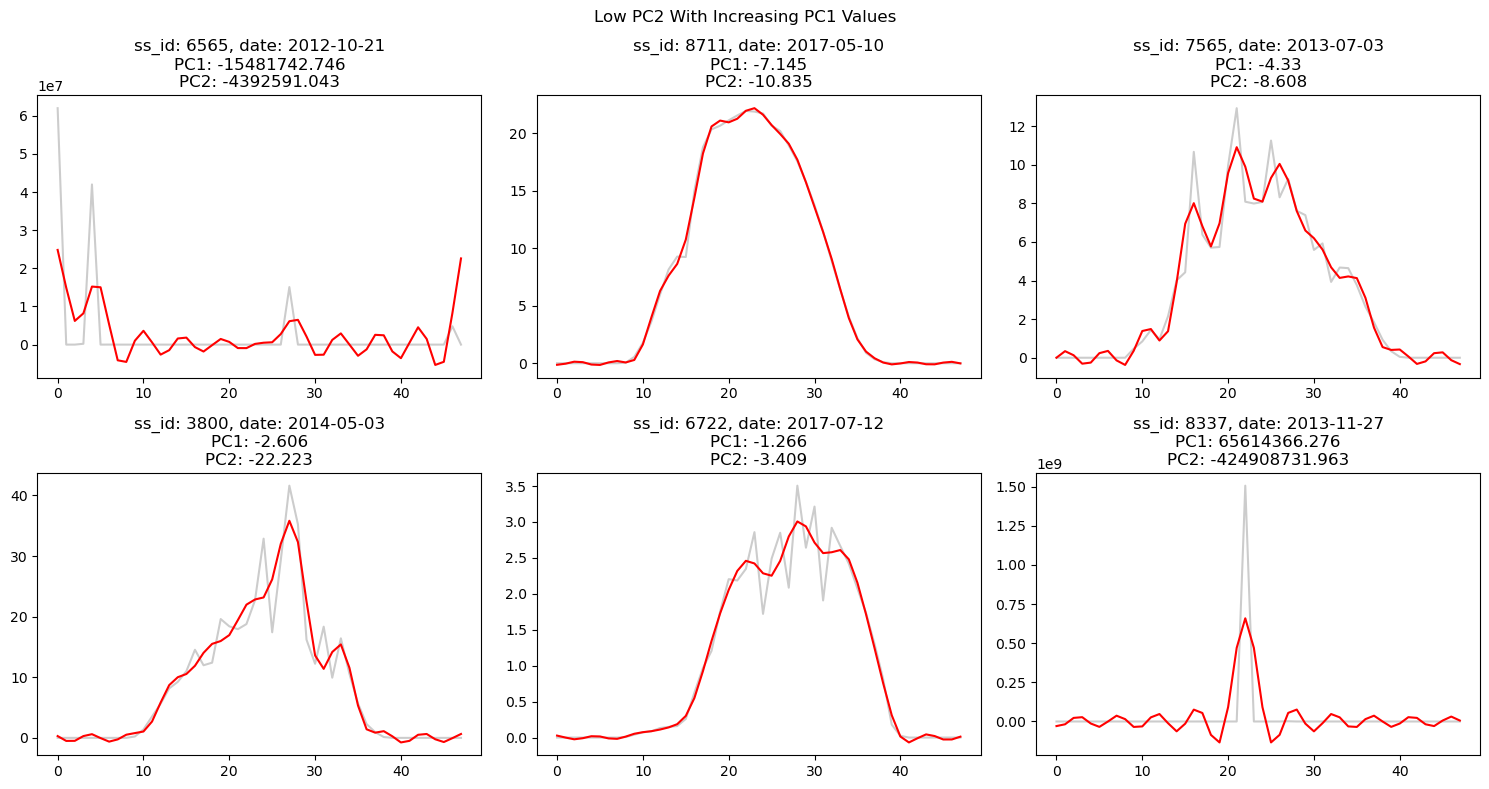

In [368]:
%%time
cutoff = -3
# Visualize power generation curves with increasing pc2 values
pc_df = plot_curves(cond = (F.col("PC2") < cutoff), # & (F.col("PC2") < pc2_mean + bound) & (F.col("PC2") > pc2_mean + bound),
                    sort_col = "PC1",
                    suptitle = "Low PC2 With Increasing PC1 Values",
                    print_text = "Number of data points with PC2 < -3:")
        

Number of data points extracted 173917
min_power
 0.01000         173336
 0.02800            149
 0.03400             18
 0.03200             12
 0.11000              6
                  ...  
 0.99464              1
 0.45278              1
 0.35280              1
 0.35624              1
-830481.99000         1
Name: count, Length: 358, dtype: int64


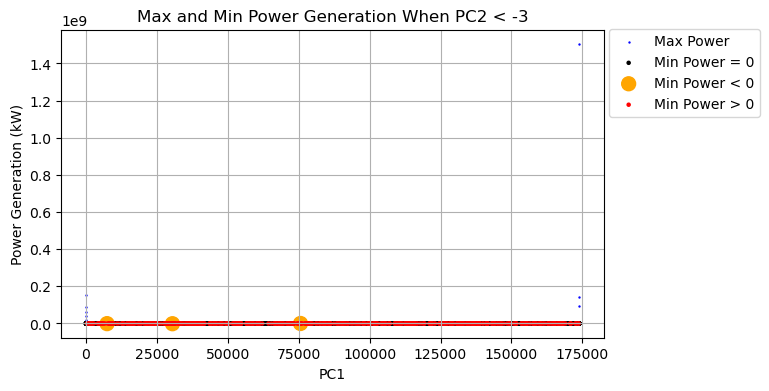

In [369]:
# Plot the maximum and minimum power_kW values for curves where PC1 < -10
print("Number of data points extracted", len(pc_df))
plot_min_max(cutoff,
             pc_df,
             x_axis = "PC1",
             main_scatter_size = 0.5)

# plt.savefig("maxmin_power_pc1fixed.png")

Number of data points extracted 173917
min_power
 0.01000         173336
 0.02800            149
 0.03400             18
 0.03200             12
 0.11000              6
                  ...  
 0.99464              1
 0.45278              1
 0.35280              1
 0.35624              1
-830481.99000         1
Name: count, Length: 358, dtype: int64


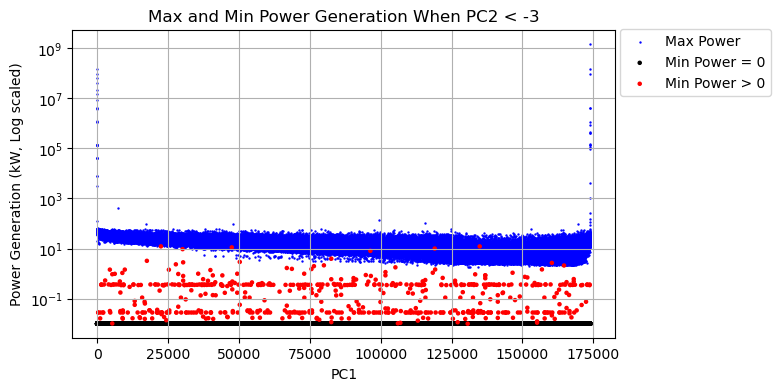

In [370]:
# Plot the maximum and minimum power_kW values for curves where PC1 < -10
print("Number of data points extracted", len(pc_df))
plot_min_max_logy(cutoff,
             pc_df,
             x_axis = "PC1",
             main_scatter_size = 0.5)

# plt.savefig("maxmin_power_pc1fixed_log.png")

## Locating the PC Boundaries for Anomalies

In [502]:
### Function for subplotting
def plot_power(df, power_type, normal_bounds):

    def plot_box(ax, pc1_l, pc1_h, pc2_l, pc2_h):
        x = np.linspace(pc1_l, pc1_h, 100)
        y = np.linspace(pc2_l, pc2_h, 100)
        ax.plot(x, [pc2_l]*100, "r--", linewidth=1)
        ax.plot(x, [pc2_h]*100, "r--", linewidth=1)
        ax.plot([pc1_l]*100, y, "r--", linewidth=1)
        ax.plot([pc1_h]*100, y, "r--", linewidth=1)

    pc1_l, pc1_h, pc2_l, pc2_h = normal_bounds
    
    fig,ax = plt.subplots(3,1, figsize=(8,10))
    
    if power_type == "max_power":
        power_type2 = "Maximum Power"
    else: 
        power_type2 = "Minimum Power"
    df[power_type2] = df[power_type]
    df.sort_values(power_type2)
    df.plot.scatter("PC1", "PC2", c=power_type2, cmap="viridis", ax=ax[0], s=5)
    df[df[power_type2] <= 50].plot.scatter("PC1", "PC2", c=power_type2, cmap="viridis", ax=ax[1], s=5)
    df[df[power_type2] <= 10].plot.scatter("PC1", "PC2", c=power_type2, cmap="viridis", ax=ax[2], s=5)
    
    ### Plot the boundaries 
    plot_box(ax[0], pc1_l, pc1_h, pc2_l, pc2_h)
    plot_box(ax[1], pc1_l, pc1_h, pc2_l, pc2_h)
    plot_box(ax[2], pc1_l, pc1_h, pc2_l, pc2_h)

    ### Other plot details
    # ax[0].set(title="Distribution of Data Points Across PC1 and PC2")
    ax[0].set(title="All Points")
    ax[1].set(title=f"{power_type2} <= 50")
    ax[2].set(title=f"{power_type2} <= 10")
    plt.suptitle(f"Distribution of Data Points Across PC1 and PC2 by {power_type2}")
    plt.tight_layout()

    return ax

There are 54309396 points within the bounding box out of 54919174 total
1017354 total points being plotted

CPU times: user 9 s, sys: 97.8 ms, total: 9.1 s
Wall time: 11.4 s


[(-30.0, 5.0), (-40.0, 5.0)]

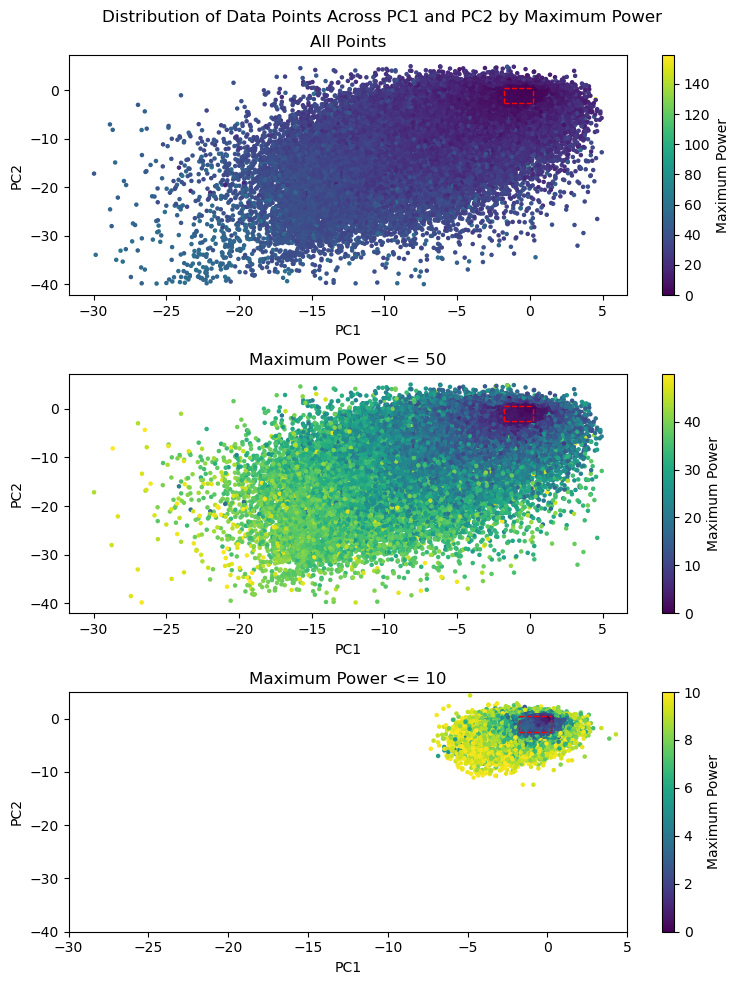

In [504]:
%%time
### Plot variables
power_type = "max_power"
pc1_l, pc1_h, pc2_l, pc2_h = (-1.75, .25, -2.5, .5)
normal_bounds = (pc1_l, pc1_h, pc2_l, pc2_h)

## Set the initial filter
cond_1 = (F.col("PC1") >= -30)
cond_2 = (F.col("PC1") <= 5) 
cond_3 = (F.col("PC2") >= -40)
cond_4 = (F.col("PC2") <= 5)
filter_out = (F.col("PC1") <= pc1_h) & (F.col("PC1") >= pc1_l) & (F.col("PC2") <= pc2_h) & (F.col("PC2") >= pc2_l)
cond_vec = cond_1 & cond_2 & cond_3 & cond_4

### Find points within the bounding box
subset_df = df.where(filter_out).select("id", "PC1", "PC2", 
                                      F.array_max(F.col("power_kW_values")).alias("max_power"),
                                      F.array_min(F.col("power_kW_values")).alias("min_power"))
print(f"There are {subset_df.count()} points within the bounding box out of {df_count} total")

### Plot the data
subset_df = df.where(filter_out).select("id", "PC1", "PC2", 
                                      F.array_max(F.col("power_kW_values")).alias("max_power"),
                                      F.array_min(F.col("power_kW_values")).alias("min_power")) \
                              .sample(0.0075)
pc_df = df.where(cond_vec & ~filter_out).select("id", "PC1", "PC2", 
                              F.array_max(F.col("power_kW_values")).alias("max_power"),
                              F.array_min(F.col("power_kW_values")).alias("min_power")) \
                      .union(subset_df) \
                      .toPandas()
print(f"{len(pc_df)} total points being plotted")
print()

ax = plot_power(pc_df, power_type, normal_bounds)
ax[2].set(xlim=[-30, 5], ylim=[-40, 5])

In [306]:
### Extracting all points that are outside of the bounding box
pc_df = df.where( ~filter_out) \
          .withColumn("max_power", F.array_max(F.col("power_kW_values")).alias("max_power")) \
          .withColumn("min_power", F.array_min(F.col("power_kW_values")).alias("min_power")) \
          .toPandas()

len(pc_df)
pc_df.to_csv("pca_anomalies.csv", header=True)

## Exploring Points Outside of the Boundaries

In [492]:
df_meta.describe()

,ss_id,latitude_rounded,longitude_rounded,orientation,tilt,kwp
count,24299.000000,24299.000000,24299.000000,24299.000000,24299.000000,24299.000000
mean,14591.825960,52.989486,-1.401896,178.082843,31.507758,2.967349
std,7028.149292,1.476230,1.388700,47.110187,6.045058,2.285005
min,2405.000000,50.040000,-6.220000,0.000000,1.000000,0.225000
25%,8512.500000,51.900000,-2.330000,150.000000,30.000000,2.280000
50%,14597.000000,52.600000,-1.480000,180.000000,30.000000,2.800000
75%,20676.500000,53.530000,-0.260000,210.000000,35.000000,3.420000
max,26770.000000,58.570000,1.750000,355.000000,65.000000,50.000000


In [493]:
pca_outliers = pc_df.merge(df_meta, on="ss_id", how="inner")

pca_outliers.describe()

,id,ss_id,PC1,PC2,latitude_rounded,longitude_rounded,orientation,tilt,kwp
count,1.737130e+05,173713.000000,1.737130e+05,1.737130e+05,173713.000000,173713.000000,173713.000000,173713.000000,173713.000000
mean,4.288580e+11,12763.535285,3.830003e+02,-3.073396e+03,52.303551,-1.216516,180.997064,24.694513,26.030940
std,2.499612e+11,7473.123410,1.929243e+05,1.026832e+06,1.268673,1.522337,49.352951,9.950392,16.590245
min,3.630000e+03,2543.000000,-1.548174e+07,-4.249087e+08,50.190000,-5.610000,1.000000,1.000000,1.500000
25%,2.147485e+11,6790.000000,-6.282695e+00,-8.750998e+00,51.470000,-2.400000,180.000000,20.000000,9.870000
50%,4.294969e+11,9707.000000,-3.409371e+00,-5.048535e+00,51.930000,-1.170000,180.000000,25.000000,27.500000
75%,6.442452e+11,20349.000000,-1.408764e+00,-3.417053e+00,52.640000,0.030000,214.000000,30.000000,41.000000
max,8.589941e+11,26707.000000,6.561437e+07,-3.000006e+00,58.570000,1.720000,315.000000,63.000000,50.000000


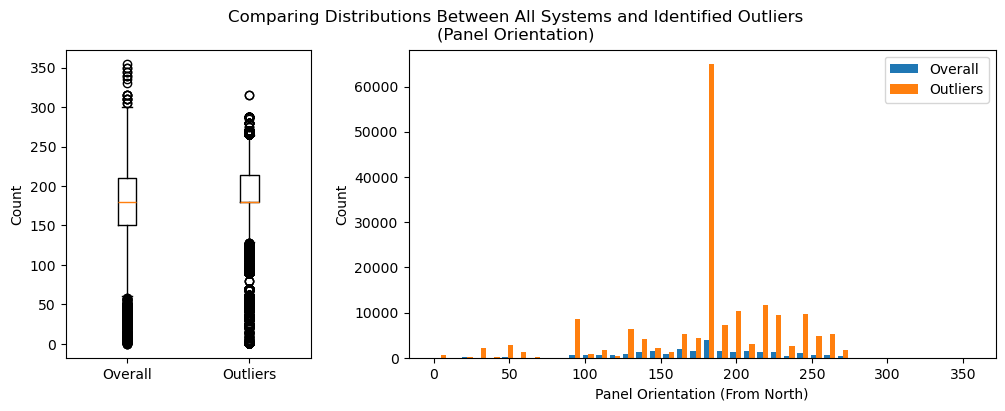

In [494]:
### Orientation --> ARCHIVED 
col = "Orientation"
df_col = col.lower()
df1 = df_meta[df_col]
df2 = pca_outliers[df_col]

# fig,ax = plt.subplots(1,2, figsize=(12,4))
fig = plt.figure(figsize=(12,4))
grid = plt.GridSpec(1,3, hspace=0.2, wspace=0.4)
box_ax = fig.add_subplot(grid[0])
hist_ax = fig.add_subplot(grid[1:])
box_ax.boxplot([df1, df2])
box_ax.set_xticklabels(["Overall", "Outliers"])
hist_ax.hist([df1, df2], bins=40, label=["Overall", "Outliers"])
hist_ax.legend()

### EDIT THESE AS NECESSARY
box_ax.set(ylabel="Count")
hist_ax.set(xlabel="Panel Orientation (From North)",
         ylabel="Count")
plt.suptitle("Comparing Distributions Between All Systems and Identified Outliers\n(Panel Orientation)")

plt.tight_layout
plt.show()

In [495]:
def distribution_plots():
    df_col = col.lower()
    df1 = df_meta[df_col]
    df2 = pca_outliers[df_col]
    
    fig = plt.figure(figsize=(10,5.6))
    grid = plt.GridSpec(2,3, hspace=0.5, wspace=0.5)
    
    box_ax = fig.add_subplot(grid[:,0])
    box_ax.boxplot([df1, df2], widths=0.65)
    box_ax.set_ylabel("Count")
    box_ax.set_xticklabels(["Overall", "Outliers"])
    
    hist_ax1 = fig.add_subplot(grid[0,1:])
    sns.histplot(df1, bins=40, label="Overall", color="c", ax=hist_ax1)
    hist_ax1.set_title("Overall Distribution")
    hist_ax1.set_ylabel("Count")
    
    hist_ax2 = fig.add_subplot(grid[1,1:])
    sns.histplot(df2, bins=40, label="Outliers", color="orange", ax=hist_ax2)
    hist_ax2.set_title("Outlier Distribution")
    hist_ax2.set_ylabel("Count")

    return (box_ax, hist_ax1, hist_ax2)

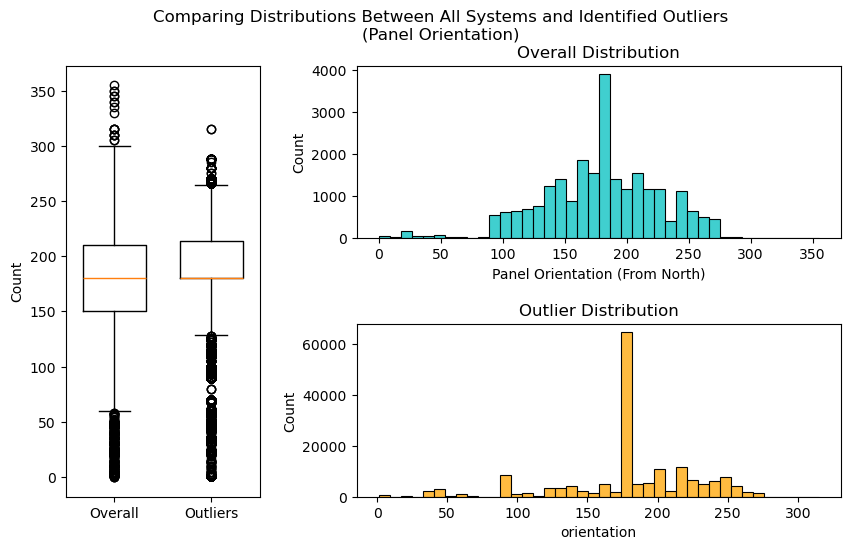

<Figure size 640x480 with 0 Axes>

In [496]:
### Orientation
col = "Orientation"
box_ax, hist_ax1, hist_ax2 = distribution_plots()

### EDIT THESE AS NECESSARY
box_ax.set(ylabel="Count")
hist_ax1.set_xlabel("Panel Orientation (From North)")
plt.suptitle("Comparing Distributions Between All Systems and Identified Outliers\n(Panel Orientation)")

plt.tight_layout
plt.show()

plt.savefig("images/pca_outliers_orientation.png")

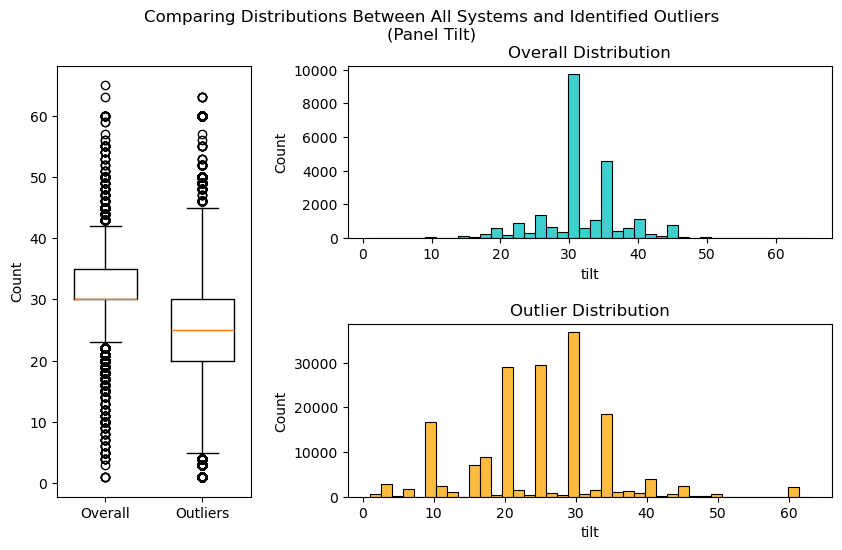

<Figure size 640x480 with 0 Axes>

In [499]:
### Orientation
col = "Tilt"
box_ax, hist_ax1, hist_ax2 = distribution_plots()

### EDIT THESE AS NECESSARY
box_ax.set(ylabel="Count")
hist_ax.set_xlabel("Panel Tilt (From Horizontal)")
plt.suptitle("Comparing Distributions Between All Systems and Identified Outliers\n(Panel Tilt)")

plt.tight_layout
plt.show()

plt.savefig("images/pca_outliers_tilt.png")

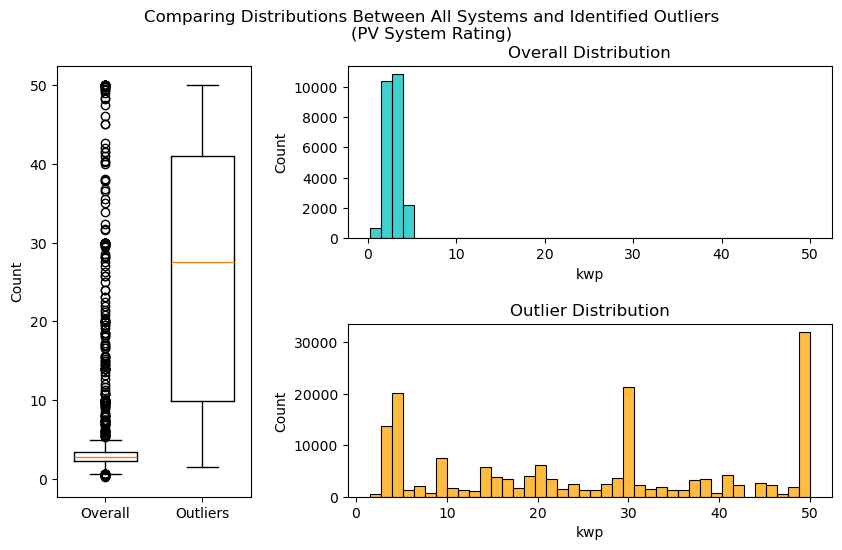

<Figure size 640x480 with 0 Axes>

In [506]:
### Orientation
col = "kwp"
box_ax, hist_ax1, hist_ax2 = distribution_plots()

### EDIT THESE AS NECESSARY
box_ax.set(ylabel="Count")
hist_ax.set_xlabel("PV System Rating (kW)")
plt.suptitle("Comparing Distributions Between All Systems and Identified Outliers\n(PV System Rating)")

plt.tight_layout
plt.show()

plt.savefig("images/pca_outliers_kwp.png")

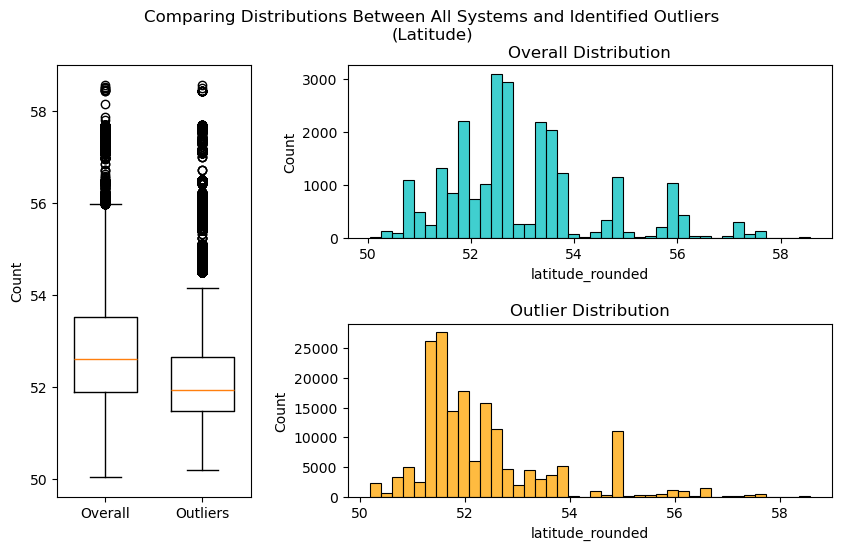

<Figure size 640x480 with 0 Axes>

In [507]:
### Orientation
col = "latitude_rounded"
box_ax, hist_ax1, hist_ax2 = distribution_plots()

### EDIT THESE AS NECESSARY
box_ax.set(ylabel="Count")
hist_ax.set_xlabel("Latitude")
plt.suptitle("Comparing Distributions Between All Systems and Identified Outliers\n(Latitude)")

plt.tight_layout
plt.show()

plt.savefig("images/pca_outliers_latitude.png")

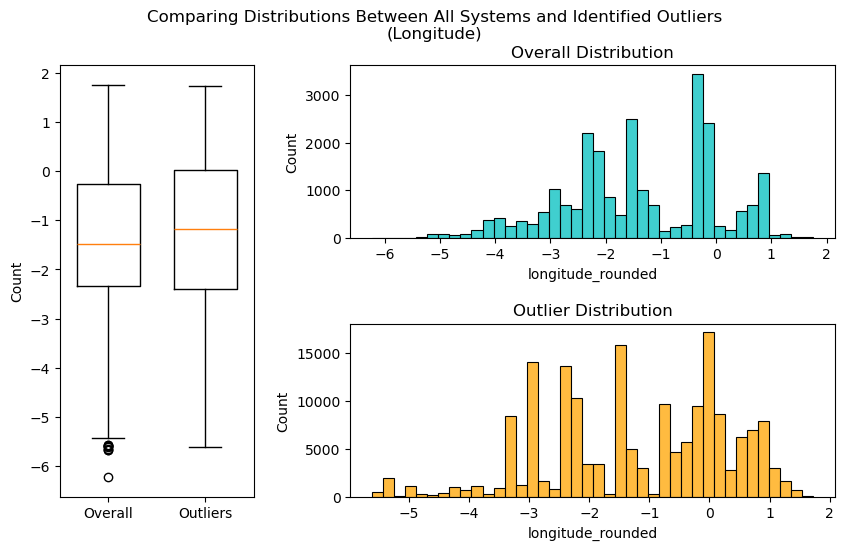

<Figure size 640x480 with 0 Axes>

In [509]:
### Orientation
col = "longitude_rounded"
box_ax, hist_ax1, hist_ax2 = distribution_plots()

### EDIT THESE AS NECESSARY
box_ax.set(ylabel="Count")
hist_ax.set_xlabel("Longitude")
plt.suptitle("Comparing Distributions Between All Systems and Identified Outliers\n(Longitude)")

plt.tight_layout
plt.show()

plt.savefig("images/pca_outliers_longitude.jpg")

# Kmeans (on the coefficients)

In [25]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
import pyspark.ml.functions as M
from pyspark.ml import Pipeline

In [26]:
# %%time
# ### Train the model on the coefficients, then extract the predicted clusters
# k=10

# print("Building model")
# kmeans = KMeans(k=k,
#                featuresCol="PC",
#                predictionCol="prediction",
#                distanceMeasure="euclidean",
#                maxIter = 100,
#                initMode = "k-means||")
# print("Fitting model")
# model = kmeans.fit(df_kmeans)
# print("Transforming dataset")
# df_kmeans1 = model.transform(df_kmeans)

# df_kmeans1.groupBy("prediction").agg(F.count("*").alias("count")).show()

In [27]:
# ### View cluster centers
# cluster_centers = np.array(model.clusterCenters())

# ## Convert cluster centers to top 2 PC
# # cluster_pc = np.dot(cluster_centers, eigvec[0:2].T)
# # cluster_dict = {"PC1":cluster_pc[:,0],
# #                 "PC2":cluster_pc[:,1],
# #                 "cluster_num":[i for i in range(0,len(cluster_centers))]
# #                 }
# cluster_dict = {"PC1":[i for i in cluster_centers[:,0]],
#                 "PC2":[i for i in cluster_centers[:,1]],
#                 "cluster_num":[i for i in range(0,len(cluster_centers))]
#                 }

# cluster_df = pd.DataFrame.from_dict(cluster_dict)

# ### Save clusters
# # cluster_df.to_csv(f"kmeans_centroids_1.csv", header=True, sep=",")
# cluster_df

In [28]:
# model.clusterCenters()

In [29]:
# df_kmeans.dtypes

In [30]:
# df_kmeans1 = df_kmeans1.select("id", "ss_id", "stamp_date", "prediction", \
#                                M.vector_to_array("PC").alias("PC")) \
#                        .select("id", "ss_id", "stamp_date", "prediction", \
#                                F.col("PC")[0].alias("PC1"), F.col("PC")[1].alias("PC2"))

In [31]:
# # Plot a sample of the 0 group with the 1 and 2 groups
# df_anomalies = df_kmeans1.where(F.col("prediction") > 0) \
#                         .select("id", "ss_id", "stamp_date", "PC1", "PC2", "prediction") 
# df_pd = df_kmeans1.where(F.col("prediction") == 0) \
#                   .sample(0.8) \
#                   .select("id", "ss_id", "stamp_date", "PC1", "PC2", "prediction") \
#                   .union(df_anomalies) \
#                   .toPandas()

# ### Save the predicted clusters
# # df_pd[df_pd["prediction"] > 0].to_csv(f"kmeans_anomalies_1.csv", header=True, sep=",")

# ### View the identified anomalies
# df_pd[df_pd["prediction"] > 0]

In [32]:

# df_pd["PC1"] / np.linalg.norm(df_pd["PC1"])

In [33]:
# ### Plot the cluster centers and resulting clusters
# # Plot variables
# color_dict = {0:"k", 1:"b", 2:"r", 3:"g", 4:"lime", 5:"y", 6:"m", 7:"c", 8:"orange", 9:"pink", 10:"brown"}
# cluster_df["color"] = cluster_df["cluster_num"].map(color_dict)

# fig,ax = plt.subplots(1,1, figsize=(8,5))

# # individual points
# for i in cluster_df["cluster_num"]:
#     df_pd_subset = df_pd[df_pd["prediction"]==i]
#     plt.plot(df_pd_subset["PC1"], df_pd_subset["PC2"], ".", color=color_dict[i], alpha=0.75)
# # cluster centroids
# c0 = ax.scatter(cluster_df["PC1"][0], cluster_df["PC2"][0], marker="X", c=cluster_df["color"][0])
# c1 = ax.scatter(cluster_df["PC1"][1], cluster_df["PC2"][1], marker="X", c=cluster_df["color"][1])
# c2 = ax.scatter(cluster_df["PC1"][2], cluster_df["PC2"][2], marker="X", c=cluster_df["color"][2])
# c3 = ax.scatter(cluster_df["PC1"][3], cluster_df["PC2"][3], marker="X", c=cluster_df["color"][3])
# c4 = ax.scatter(cluster_df["PC1"][4], cluster_df["PC2"][4], marker="X", c=cluster_df["color"][4])
# c5 = ax.scatter(cluster_df["PC1"][5], cluster_df["PC2"][5], marker="X", c=cluster_df["color"][5])
# c6 = ax.scatter(cluster_df["PC1"][6], cluster_df["PC2"][6], marker="X", c=cluster_df["color"][6])
# c7 = ax.scatter(cluster_df["PC1"][7], cluster_df["PC2"][7], marker="X", c=cluster_df["color"][7])
# c8 = ax.scatter(cluster_df["PC1"][8], cluster_df["PC2"][8], marker="X", c=cluster_df["color"][8])
# c9 = ax.scatter(cluster_df["PC1"][9], cluster_df["PC2"][9], marker="X", c=cluster_df["color"][9])
# ax.legend([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9], 
#           ["0: Normal", "1: Anomaly", "2: Anomaly", "3: Anomaly", "4: Anomaly", "5: Anomaly", "6: Anomaly", "7: Anomaly",
#           "8: Anomaly", "9: Anomaly"],
#          loc="upper right", bbox_to_anchor=(1.25,1))

# ax.set(xlabel="PC1",
#       ylabel="PC2",
#       title="Plotting Coefficient Clusters Along the Top 2 Principal Components\n(20% of Normal Points Shown)")
# plt.show()

## Kmeans with the initial anomalies filtered out

In [34]:
# ### Filter out the anomalies
# # ids from kmeans:
# # 111669615855
# # 292057975372
# # 412317027711
# # 609885816012
# # df_kmeans2 = df_pc2.withColumn("coefficients", M.array_to_vector(F.col("coefficients"))) \
# #                    .where(~(F.col("id").isin(kmeans4_anomaly_ids)))
# df_kmeans2 = df_pc2.withColumn("coefficients", M.array_to_vector(F.col("coefficients"))) \
#                    .where(F.col("id")!=F.lit(111669615855)) \
#                    .where(F.col("id")!=F.lit(292057975372)) \
#                    .where(F.col("id")!=F.lit(412317027711)) \
#                    .where(F.col("id")!=F.lit(609885816012)) 
# k=10

# print("Building model")
# kmeans = KMeans(k=k,
#                featuresCol="coefficients",
#                predictionCol="prediction",
#                distanceMeasure="euclidean",
#                maxIter = 100)
# print("Fitting model")
# model = kmeans.fit(df_kmeans2)
# print("Transforming dataset")
# df_kmeans2 = model.transform(df_kmeans2)

# df_kmeans2.groupBy("prediction").agg(F.count("*").alias("count")).show()


In [35]:
# ### View cluster centers
# cluster_centers = model.clusterCenters()

# ## Convert cluster centers to top 2 PC
# cluster_pc = np.dot(cluster_centers, eigvec[0:2].T)
# cluster_dict = {"PC1":cluster_pc[:,0],
#                 "PC2":cluster_pc[:,1],
#                 "cluster_num":[i for i in range(0,len(cluster_centers))]
#                 }

# cluster_df = pd.DataFrame.from_dict(cluster_dict)

# ### Save clusters
# cluster_df.to_csv(f"kmeans_centroids_2.csv", header=True, sep=",")
# cluster_df

In [36]:
# # Plot a sample of the 0 group with the 1 and 2 groups
# df_anomalies = df_kmeans2.where(F.col("prediction") > 0) \
#                         .select("id", "ss_id", "stamp_date", "PC1", "PC2", "prediction") 
# df_pd = df_kmeans2.where(F.col("prediction") == 0) \
#                   .sample(0.5) \
#                   .select("id", "ss_id", "stamp_date", "PC1", "PC2", "prediction") \
#                   .union(df_anomalies) \
#                   .toPandas()

# ### Save the predicted clusters
# df_pd[df_pd["prediction"] > 0].to_csv(f"kmeans_anomalies_2.csv", header=True, sep=",")

# ### View the identified anomalies
# df_pd[df_pd["prediction"] > 0]

In [37]:
# ### Plot the cluster centers and resulting clusters
# # Plot variables
# color_dict = {0:"k", 1:"b", 2:"r", 3:"g", 4:"lime", 5:"y", 6:"m", 7:"c", 8:"orange", 9:"pink", 10:"brown"}
# cluster_df["color"] = cluster_df["cluster_num"].map(color_dict)

# fig,ax = plt.subplots(1,1, figsize=(8,5))

# # individual points
# for i in cluster_df["cluster_num"]:
#     df_pd_subset = df_pd[df_pd["prediction"]==i]
#     plt.plot(df_pd_subset["PC1"], df_pd_subset["PC2"], ".", color=color_dict[i], alpha=0.75)
# # cluster centroids
# clust1 = ax.scatter(cluster_df["PC1"][0], cluster_df["PC2"][0], marker="X", c=cluster_df["color"][0])
# clust2 = ax.scatter(cluster_df["PC1"][1], cluster_df["PC2"][1], marker="X", c=cluster_df["color"][1])
# clust3 = ax.scatter(cluster_df["PC1"][2], cluster_df["PC2"][2], marker="X", c=cluster_df["color"][2])
# clust4 = ax.scatter(cluster_df["PC1"][3], cluster_df["PC2"][3], marker="X", c=cluster_df["color"][3])
# clust5 = ax.scatter(cluster_df["PC1"][4], cluster_df["PC2"][4], marker="X", c=cluster_df["color"][4])
# clust6 = ax.scatter(cluster_df["PC1"][5], cluster_df["PC2"][5], marker="X", c=cluster_df["color"][5])
# clust7 = ax.scatter(cluster_df["PC1"][6], cluster_df["PC2"][6], marker="X", c=cluster_df["color"][6])
# clust8 = ax.scatter(cluster_df["PC1"][7], cluster_df["PC2"][7], marker="X", c=cluster_df["color"][7])
# clust9 = ax.scatter(cluster_df["PC1"][8], cluster_df["PC2"][8], marker="X", c=cluster_df["color"][8])
# ax.legend([clust1, clust2, clust3, clust4, clust5, clust6, clust7], 
#           ["0: Normal", "1: Anomaly", "2: Anomaly", "3: Anomaly", "4: Anomaly", "5: Anomaly", "6: Anomaly", "7: Anomaly",
#           "8: Anomaly", "9: Anomaly"],
#          loc="upper right", bbox_to_anchor=(1.25,1))

# ax.set(xlabel="PC1",
#       ylabel="PC2",
#       title="Plotting Coefficient Clusters Along the Top 2 Principal Components\n(50% of Normal Points Shown)")
# plt.show()

## Kmeans with the secondary anomalies filtered out

In [38]:
# df_pd[df_pd["prediction"] > 0]

In [39]:
# ### Filter out the anomalies
# # ids from kmeans:
# # 111669615855
# # 292057975372
# # 412317027711
# # 609885816012
# # df_kmeans2 = df_pc2.withColumn("coefficients", M.array_to_vector(F.col("coefficients"))) \
# #                    .where(~(F.col("id").isin(kmeans4_anomaly_ids)))
# df_kmeans3 = df_pc2.withColumn("coefficients", M.array_to_vector(F.col("coefficients"))) \
#                    .where(F.col("id")!=F.lit(111669615855)) \
#                    .where(F.col("id")!=F.lit(292057975372)) \
#                    .where(F.col("id")!=F.lit(412317027711)) \
#                    .where(F.col("id")!=F.lit(609885816012)) \
#                    .where(F.col("id")!=F.lit(42950064702)) \
#                    .where(F.col("id")!=F.lit(214748827128)) \
#                    .where(F.col("id")!=F.lit(257698225532)) \
#                    .where(F.col("id")!=F.lit(317827764610)) \
#                    .where(F.col("id")!=F.lit(326417700448)) \
#                    .where(F.col("id")!=F.lit(343597845494)) \
#                    .where(F.col("id")!=F.lit(618475480510)) \
#                    .where(F.col("id")!=F.lit(850404002391)) \
#                    .where(F.col("id")!=F.lit(858993938512)) 
# k=10

# print("Building model")
# kmeans = KMeans(k=k,
#                featuresCol="coefficients",
#                predictionCol="prediction",
#                distanceMeasure="euclidean",
#                maxIter = 100)
# print("Fitting model")
# model = kmeans.fit(df_kmeans3)
# print("Transforming dataset")
# df_kmeans3 = model.transform(df_kmeans3)

# df_kmeans3.groupBy("prediction").agg(F.count("*").alias("count")).show()


In [40]:
# ### View cluster centers
# cluster_centers = model.clusterCenters()

# ## Convert cluster centers to top 2 PC
# cluster_pc = np.dot(cluster_centers, eigvec[0:2].T)
# cluster_dict = {"PC1":cluster_pc[:,0],
#                 "PC2":cluster_pc[:,1],
#                 "cluster_num":[i for i in range(0,len(cluster_centers))]
#                 }

# cluster_df = pd.DataFrame.from_dict(cluster_dict)

# ### Save clusters
# cluster_df.to_csv(f"kmeans_centroids_3.csv", header=True, sep=",")
# cluster_df

In [41]:
# # Plot a sample of the 0 group with the 1 and 2 groups
# df_anomalies = df_kmeans3.where(F.col("prediction") > 0) \
#                         .select("id", "ss_id", "stamp_date", "PC1", "PC2", "prediction") 
# df_pd = df_kmeans3.where(F.col("prediction") == 0) \
#                   .sample(0.5) \
#                   .select("id", "ss_id", "stamp_date", "PC1", "PC2", "prediction") \
#                   .union(df_anomalies) \
#                   .toPandas()

# ### Save the predicted clusters
# df_pd[df_pd["prediction"] > 0].to_csv(f"kmeans_anomalies_3.csv", header=True, sep=",")

# ### View the identified anomalies
# df_pd[df_pd["prediction"] > 0]

In [42]:
# ### Plot the cluster centers and resulting clusters
# # Plot variables
# color_dict = {0:"k", 1:"b", 2:"r", 3:"g", 4:"lime", 5:"y", 6:"m", 7:"c", 8:"orange", 9:"pink", 10:"brown"}
# cluster_df["color"] = cluster_df["cluster_num"].map(color_dict)

# fig,ax = plt.subplots(1,1, figsize=(8,5))

# # individual points
# for i in cluster_df["cluster_num"]:
#     df_pd_subset = df_pd[df_pd["prediction"]==i]
#     plt.plot(df_pd_subset["PC1"], df_pd_subset["PC2"], ".", color=color_dict[i], alpha=0.75)
# # cluster centroids
# clust1 = ax.scatter(cluster_df["PC1"][0], cluster_df["PC2"][0], marker="X", c=cluster_df["color"][0])
# clust2 = ax.scatter(cluster_df["PC1"][1], cluster_df["PC2"][1], marker="X", c=cluster_df["color"][1])
# clust3 = ax.scatter(cluster_df["PC1"][2], cluster_df["PC2"][2], marker="X", c=cluster_df["color"][2])
# clust4 = ax.scatter(cluster_df["PC1"][3], cluster_df["PC2"][3], marker="X", c=cluster_df["color"][3])
# clust5 = ax.scatter(cluster_df["PC1"][4], cluster_df["PC2"][4], marker="X", c=cluster_df["color"][4])
# clust6 = ax.scatter(cluster_df["PC1"][5], cluster_df["PC2"][5], marker="X", c=cluster_df["color"][5])
# clust7 = ax.scatter(cluster_df["PC1"][6], cluster_df["PC2"][6], marker="X", c=cluster_df["color"][6])
# clust8 = ax.scatter(cluster_df["PC1"][7], cluster_df["PC2"][7], marker="X", c=cluster_df["color"][7])
# clust9 = ax.scatter(cluster_df["PC1"][8], cluster_df["PC2"][8], marker="X", c=cluster_df["color"][8])
# ax.legend([clust1, clust2, clust3, clust4, clust5, clust6, clust7], 
#           ["0: Normal", "1: Anomaly", "2: Anomaly", "3: Anomaly", "4: Anomaly", "5: Anomaly", "6: Anomaly", "7: Anomaly",
#           "8: Anomaly", "9: Anomaly"],
#          loc="upper right", bbox_to_anchor=(1.25,1))

# ax.set(xlabel="PC1",
#       ylabel="PC2",
#       title="Plotting Coefficient Clusters Along the Top 2 Principal Components\n(50% of Normal Points Shown)",
#       yscale="log",
#       xscale="log")
# plt.show()

In [43]:
# ### PCA from MLLib

# df2 = df.select("ss_id", "stamp_date", F.col("coefficients").alias("coef")) \
#         .select(["ss_id", "stamp_date"] + [value.alias(f"coef_{i}") for i,value in enumerate([F.col("coef")[i] for i in range(0, 21)])]) \
#         .withColumn("id", F.monotonically_increasing_id())

# # VectorAssembler
# assembler = VectorAssembler(inputCols = [f"coef_{i}" for i in range(0, 21)],
#                             outputCol = "features")
# df2 = assembler.transform(df2)

# pca = PCA(k=2, inputCol="features", outputCol="pcaCoefficients")
# model = pca.fit(df2)

# result = model.transform(df2).select("pcaCoefficients").cache()
# result.show(5)

In [44]:
# plot_result = result.withColumn("pcaCoefficients", M.vector_to_array("pcaCoefficients")) \
#                     .select(F.col("pcaCoefficients")[0].alias("PC1"), \
#                             F.col("pcaCoefficients")[1].alias("PC2") \
#                            ) \
#                     .toPandas()
    
# # plot_result.plot.scatter("PC1", "PC2")
# plt.xlabel("PC 1")
# plt.ylabel("PC 2")
# plt.title("Plotting the Data Along the Top Two Principal Components")

# Distance from Mean

In [45]:
# ### Compute the distance between each point and the global mean
# inputCols = [f"coef_{i}" for i in range(0, 21)]

# # Global mean = colMeans
# def get_distance(col, colMeans):
#     return np.linalg.norm(np.array(col) - np.array(colMeans))
# udf_get_distance = F.udf(get_distance, ArrayType(FloatType()))

# df2 = df.withColumn("id", F.monotonically_increasing_id()) 

# rdd_distFromMean = df2.select("id", "ss_id", "stamp_date", "coefficients") \
#                       .rdd.map(lambda a: (a[0],a[1],a[2], float(np.linalg.norm(np.array(a[3] - colMeans))))) \
#                       .toDF(["id", "ss_id", "stamp_date", "dist_from_mean"])

# rdd_distFromMean.show(1)

# rdd_distFromMean_hist = df2.select("id", "ss_id", "stamp_date", "coefficients") \
#                            .rdd.map(lambda a: (a[0],a[1],a[2], float(np.linalg.norm(np.array(a[3] - colMeans))))) \
#                            .toDF(["id", "ss_id", "stamp_date", "dist_from_mean"])

# df_binned = df2.select("id", "ss_id", "stamp_date", "coefficients") \
#                .rdd.map(lambda a: (a[0],a[1],a[2], int(np.ceil(np.linalg.norm(np.array(a[3] - colMeans)))))) \
#                .toDF(["id", "ss_id", "stamp_date", "dist_from_mean"]) \
#                # .groupBy("dist_from_mean") \
#                # .agg(F.count("*").alias("Count")) \
#                # .select(F.col("dist_from_mean").alias("Bin"), "Count") \
#                # .orderBy("Bin") \
   
# bin_counts = df_binned.select(F.col("dist_from_mean").alias("Binned_dist_from_mean")).toPandas()

In [46]:
# df_hist = bin_counts.value_counts().reset_index()
# df_hist.head(3)

In [47]:
# plt.hist(df_hist["Binned_dist_from_mean"], bins=50)
# plt.title("Distributions of Coefficient Distance From the Mean")
# plt.xlabel("L2 Distance Between Coefficient Vector and the Mean Vector")
# plt.ylabel("Frequency")
# plt.show()

In [48]:
# plt.hist(df_hist["Binned_dist_from_mean"], bins=100, log=True)
# plt.title("Distributions of Coefficient Distance From the Mean\n(Log Scale)")
# plt.xlabel("L2 Distance Between Coefficient Vector and the Mean Vector")
# plt.ylabel("Frequency")
# plt.show()

In [49]:
# plt.hist(df_hist[df_hist["Binned_dist_from_mean"] < 1e6]["Binned_dist_from_mean"], bins=100, log=True)
# plt.title("Distributions of Coefficient Distance From the Mean")
# plt.xlabel("L2 Distance Between Coefficient Vector and the Mean Vector")
# plt.ylabel("Frequency")
# plt.show()

# OneVsRest

In [50]:
from pyspark.ml.classification import OneVsRest, LinearSVC

In [51]:
# # Set up classifier
# svm = LinearSVC()
# clf = OneVsRest(classifier=svm,
#                 featuresCol = "coefficients_vec"
#                 labelCol = "

# Isolation Forest



In [52]:
### ALgorithm: Binary trees
#
# Create (n_estimators) trees:
#      Choose a random feature from a subset (max_features), then chooose a random split value within its range
# Choose a random sample of the data (max_samples)
# Repeat recursively until max_splits or data point is isolated:
#      Separate data points to the left/right of the split value
#
# Track the path length of a data point through an isolation tree

In [53]:

# # Base df
# df2 = df.withColumn("coef", F.col("coefficients")) \
#         .withColumn("id", F.monotonically_increasing_id()) \
#         .select(["id", "ss_id", "stamp_date", "coefficients"] + \
#                 [value.alias(f"coef_{i}") for i,value in enumerate([F.col("coef")[i] for i in range(0, 21)])]) \
# # Training data
# inputCols = [f"coef_{i}" for i in range(0, 21)]
# dftrain = df2.select(["id"]inputCols)

# # Initialize the model
# clf = IsolationForest(contamination=0.1,
#                      max_features = 1,
#                      max_samples = 0.2,
#                      n_estimators = 100
#                     )

# # Train the model
# # model = clf.fit(dftrain)

In [54]:
# %%time
# ### Prepare data for the isolation forest
# inputCols = [f"coef_{i}" for i in range(0, 21)]

# assembler = VectorAssembler(inputCols = inputCols,
#                             outputCol = "features")

# df2 = df.withColumn("coef", F.col("coefficients")) \
#         .withColumn("id", F.monotonically_increasing_id()) \
#         .select(["id", "ss_id", "stamp_date", "coefficients"] + \
#                 [value.alias(f"coef_{i}") for i,value in enumerate([F.col("coef")[i] for i in range(0, 21)])]) \

# df2 = assembler.transform(df2).select("id", "ss_id", "stamp_date", "coefficients", "features").cache()

# df2.show(5)

# ### Set up parameters
# isolationForest_params = { \
#     bootstrap: False,
#     contamination: 0.1, # sklearn old default
#     contaminationError: 0.01 * contamination, # Recommended by synapse.ml
#     featuresCol: "features",
#     maxFeatures: 1,
#     maxSamples: 0.2,
#     numEstimators: 100,
#     predictionCol: "prediction",
#     scoreCol: "score",
# }

In [55]:
# %%time
# ### Train the isolation forest
# model = IsolationForest(bootstrap = False)